## ABOUBAKAR Ouattara

## Stratégie de couverture de Black-Scholes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
# paramètre numerique
n = 1000
m = 10000
sigma = 0.3
T = 1.5
S0 = 100
valeur_mu = [0.02,0.05,0.45]
delta = T/n


## QUESTION 1

dans cette question nous allons simuler 1000 trajectoires de $S_t$ pour differents valeur de $\mu$
le processus $S_t$ est donné par:

$$
S_t = S_0 \exp\left( \left( \mu - \frac{\sigma^2}{2} \right)t + \sigma W_t \right)
$$

ou $W_t$ est le mouvement brownien standard.


In [3]:
def brownien(n, T, m):
    delta = T/n # delta de temps

    t = np.linspace(0, T, n+1) # discretisation des points

    # simulation de m trajectoire 
    Z = np.random.normal(0, 1, (n, m)) # simulation de normal centré reduit en tant que matrice (n; m)
    dW = np.sqrt(delta) * Z  # stock la difference entre W_{t_{i+1}} - W_{t_i}

    W = np.zeros((n +1, m)) # matrice pour stimuilé les trajectoires

    # remplissage de la matrice
    W[1:, :] = np.cumsum(dW, axis=0)
    return W, t

def S_t(n, mu, m, T, sigma, S0):
    W, t = brownien(n, T, m) # permet d'avoir le mouvement brownien et la discretisation 
    t = t.reshape(-1, 1)
    # Calcule les trajectoires de S_t à partir de W_t
    S_t = S0 * np.exp((mu - sigma**2 / 2) * t + sigma * W)

    return S_t

Pour mu = 0.02 :
Moyenne: 101.84, Variance: 1491.74
*********************************************************************************
Pour mu = 0.05 :
Moyenne: 107.35, Variance: 1665.21
*********************************************************************************
Pour mu = 0.45 :
Moyenne: 195.75, Variance: 5562.89
*********************************************************************************


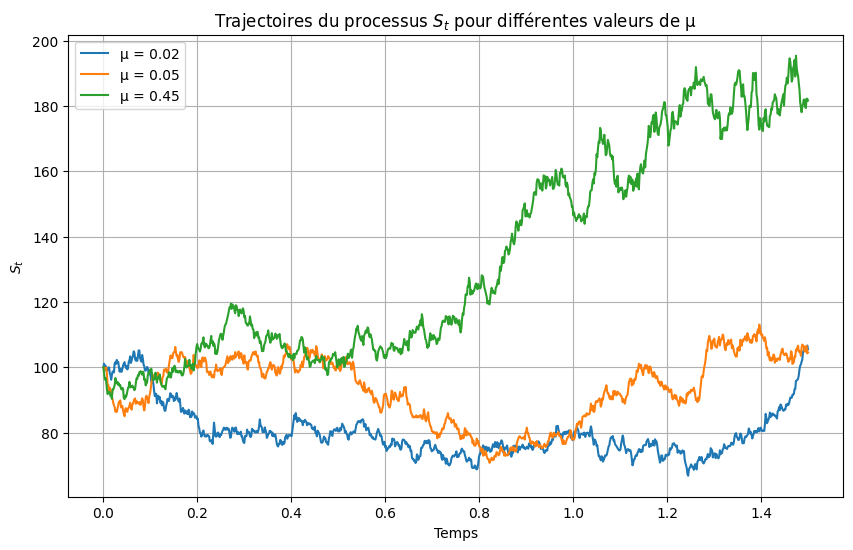

In [4]:
# Simulons les trajectoires pour chaque valeur de mu et traçons une trajectoire pour chaque mu
W, t = brownien(n, T, m)

plt.figure(figsize=(10, 6))

trajectoire = {}
for mu in valeur_mu:
    
    # Simuler les trajectoires de S_t à partir de la fonction S_t
    S = S_t(n, mu, m, T, sigma, S0)
    trajectoire[mu] = S
    # Calcul de la moyenne et variance
    mean_trajectoire = np.mean(S, axis=1)
    var_trajectoire = np.var(S, axis=1)

    print(f"Pour mu = {mu} :")
    print(f"Moyenne: {mean_trajectoire[-1]:.2f}, Variance: {var_trajectoire[-1]:.2f}")
    print("*********************************************************************************")

    # Tracer la première trajectoire pour chaque mu
    plt.plot(t, S[:, 0], label=f'μ = {mu}')

plt.title('Trajectoires du processus $S_t$ pour différentes valeurs de μ')
plt.xlabel('Temps')
plt.ylabel('$S_t$')
plt.legend()
plt.grid(True)
plt.show()

un $\mu$ très important entraine une moyenne et variance très importante. Pour s'en convaincre nous pouvons ecrire:
$$
\begin{align*}
    \mathbb E[S_T] &= \exp\left(\left(\mu - \frac{\sigma^2}{2}\right)T\right)\mathbb E\left[\exp(\sigma W_T) \right] \\
    \mathrm{Var}\left(S_T\right) &= \exp((2\mu-\sigma^2)T)\mathrm{Var}\left(\exp(\sigma W_T)\right)
\end{align*}
$$

## QUESTION 2

## Question(a et b)

On peut simuler $X_{T}^{n}(S, K) $ grâce à la formule suivante:

$$
\begin{equation}
e^{-rT} X_n^T(S, K) = BS(S_0, K, T) + \sum_{i=1}^{n} \Delta_{t_{n_{i-1}}} (S_{t_{n_{i-1}}}, K) \left( e^{-rt_{n_i}} S_{t_{n_i}} - e^{-rt_{n_{i-1}}} S_{t_{n_{i-1}}} \right)
\end{equation}
$$

Avec: $BS(S_0, K, T)$ le prix Black-Sholes

In [5]:
def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

def calcule_delta(S, K, T, r, sigma, t):
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
    return norm.cdf(d1)

def Xn_T(S0, mu, sigma, T, n, m, r, valeur_K):

    S = S_t(n, mu, m, T, sigma, S0)  # Simuler les trajectoires de S_t
    t = np.linspace(0, T, n + 1)  # Grille de temps
    Xn_T = np.zeros((len(valeur_K), m))  # Stocker les résultats

    for k, K in enumerate(valeur_K):
        BS_price = black_scholes(S0, K, T, r, sigma)  # Prix selon Black-Scholes
        sum_term = np.zeros(m)  # Pour chaque trajectoire
        
        for i in range(1, n + 1):
            delta_tni = calcule_delta(S[i - 1], K, T, r, sigma, t[i - 1])
            diff_term = np.exp(-r * t[i]) * S[i] - np.exp(-r * t[i - 1]) * S[i - 1]
            sum_term += delta_tni * diff_term

        Xn_T[k, :] = np.exp(r * T) * (BS_price + sum_term)

    return Xn_T


In [6]:
r = 0.05
valeur_K = np.arange(80, 121, 2)  # K dans {80, 82, 84, ..., 120}

# Simuler pour chaque mu et stocker les résultats
Xn_T_resultats = {}
mean_resultats = {}
var_resultats= {}

for mu in valeur_mu:
    Xn = Xn_T(S0, mu, sigma, T, n, m, r, valeur_K)
    Xn_T_resultats[f"mu: {mu:.2f}"] = Xn
    mean_resultats[f"mu: {mu:.2f}"] = np.mean(Xn, axis=1)  # Moyenne
    var_resultats[f"mu: {mu:.2f}"] = np.var(Xn, axis=1)    # Variance

print("moyenne Xn_T des differents mu")
print( mean_resultats)
print("************************************************************************************************************")
print("variance Xn_T des differents mu")
print( var_resultats)


moyenne Xn_T des differents mu
{'mu: 0.02': array([28.18068008, 26.81907589, 25.50517387, 24.24012234, 23.02333029,
       21.85539406, 20.73690934, 19.66637386, 18.6412865 , 17.65632577,
       16.71089989, 15.80797318, 14.94448205, 14.11887017, 13.33159299,
       12.58222924, 11.86781342, 11.18855114, 10.54305746,  9.9296404 ,
        9.34777786]), 'mu: 0.05': array([31.34134679, 29.89212324, 28.48952366, 27.13153579, 25.81871274,
       24.55201379, 23.3320192 , 22.16026338, 21.0360141 , 19.95791444,
       18.9254124 , 17.93962799, 17.00015132, 16.1037458 , 15.24636201,
       14.42623634, 13.64372254, 12.90072311, 12.19410329, 11.52075148,
       10.8817362 ]), 'mu: 0.45': array([117.26424932, 115.28584187, 113.31163941, 111.34211807,
       109.37799301, 107.42041275, 105.46913913, 103.52624094,
       101.59252695,  99.66784342,  97.75401421,  95.85224999,
        93.96203827,  92.08434241,  90.21799703,  88.36462446,
        86.5249567 ,  84.69868912,  82.8888958 ,  81.0972208

Nous avons constater precedement qu'un drift ($\mu$) élévé entraiine un prix moyen élévé et un variance élévé de l'actif. Maintenant nous constactons egalement que cela entraînent une diminution plus rapide de la valeur du portefeuille par rapport au prix d'exercice.

## Question (c et d)

In [7]:
def calculer_PLn_T(S0, mu, sigma, T, n, m, r, valeur_K):
    # Simuler les trajectoires de S_t
    S = S_t(n, mu, m, T, sigma, S0)  # Simuler les trajectoires de S_t
    S_T = S[-1]  # Valeur de S_T pour chaque trajectoire (S_T correspond à S[n])
    
    # Calculer X_n^T(S, K) pour chaque valeur de K
    Xn = Xn_T(S0, mu, sigma, T, n, m, r, valeur_K)

    # Initialiser la matrice pour stocker les gains et pertes
    PLn_T = np.zeros((len(valeur_K), m))

    # Calcul des gains et pertes pour chaque K
    for k, K in enumerate(valeur_K):
        # Payoff (S_T - K)^+
        payoff = np.maximum(S_T - K, 0)
        
        # Calcul des gains et pertes : PL_n^T(S, K) = X_n^T(S, K) - (S_T - K)^+
        PLn_T[k, :] = Xn[k, :] - payoff

    return PLn_T
    

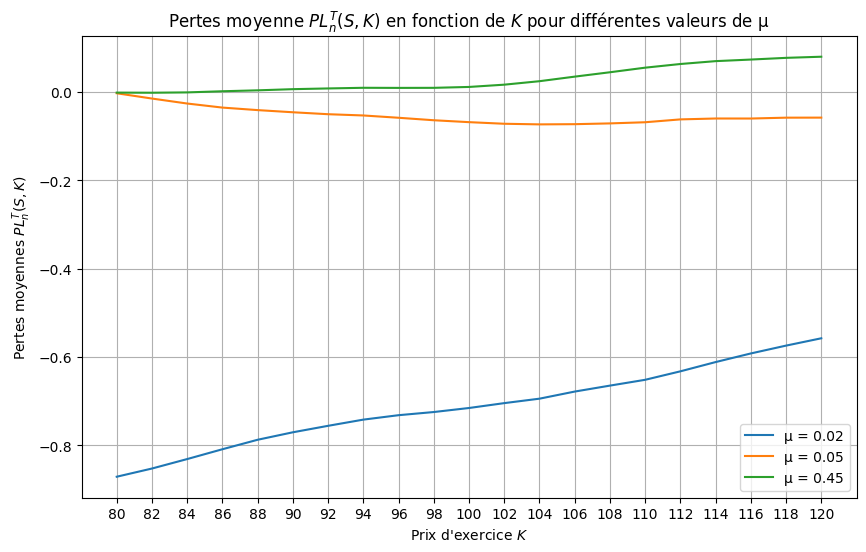

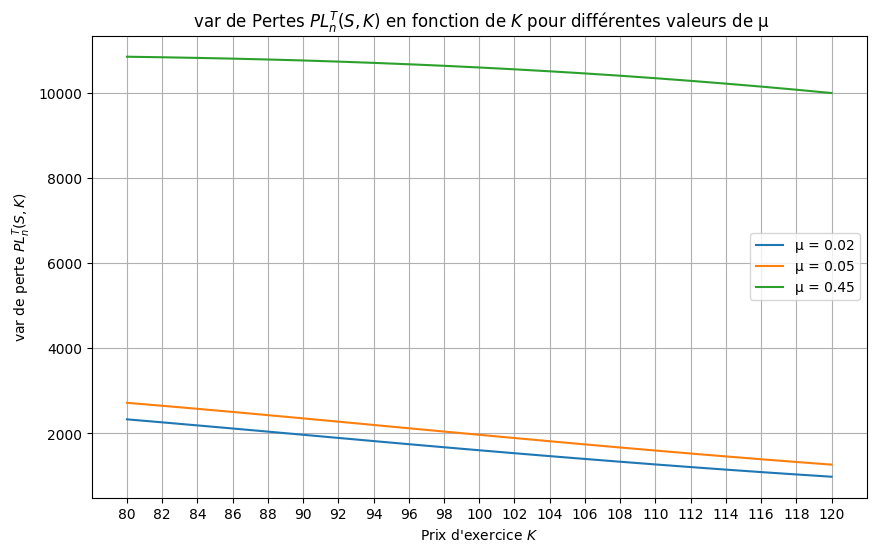

In [8]:
# Simuler les pertes pour chaque mu et stocker les moyennes
mean_PLn_T_resultats = {}
var_PLn_T_resultats = {}
for mu in valeur_mu:
    PLn_T = calculer_PLn_T(S0, mu, sigma, T, n, m, r, valeur_K)
    mean_PLn_T_resultats[mu] = np.mean(PLn_T, axis=1)  # Moyenne des pertes pour chaque K
    var_PLn_T_resultats[mu]= np.var(PLn_T, axis=1)

# Tracer les pertes en fonction de K pour chaque mu
plt.figure(figsize=(10, 6))

for mu in valeur_mu:
    plt.plot(valeur_K, mean_PLn_T_resultats[mu], label=f'μ = {mu}')

plt.title('Pertes moyenne $PL_n^T(S, K)$ en fonction de $K$ pour différentes valeurs de μ')
plt.xlabel('Prix d\'exercice $K$')
plt.ylabel('Pertes moyennes $PL_n^T(S, K)$')
plt.xticks(valeur_K)  # Afficher les valeurs de K sur l'axe des x
plt.legend()
plt.grid(True)
plt.show()


# Tracer les variances des pertes en fonction de K pour chaque mu
plt.figure(figsize=(10, 6))

for mu in valeur_mu:
    plt.plot(valeur_K, var_PLn_T_resultats[mu], label=f'μ = {mu}')

plt.title(' var de Pertes $PL_n^T(S, K)$ en fonction de $K$ pour différentes valeurs de μ')
plt.xlabel('Prix d\'exercice $K$')
plt.ylabel('var de perte $PL_n^T(S, K)$')
plt.xticks(valeur_K)  # Afficher les valeurs de K sur l'axe des x
plt.legend()
plt.grid(True)
plt.show()

Pour $ n = 100$

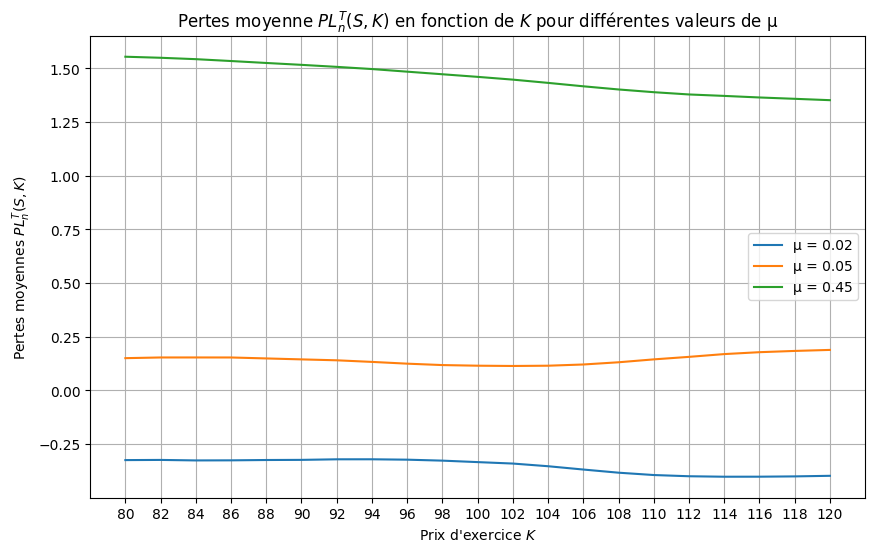

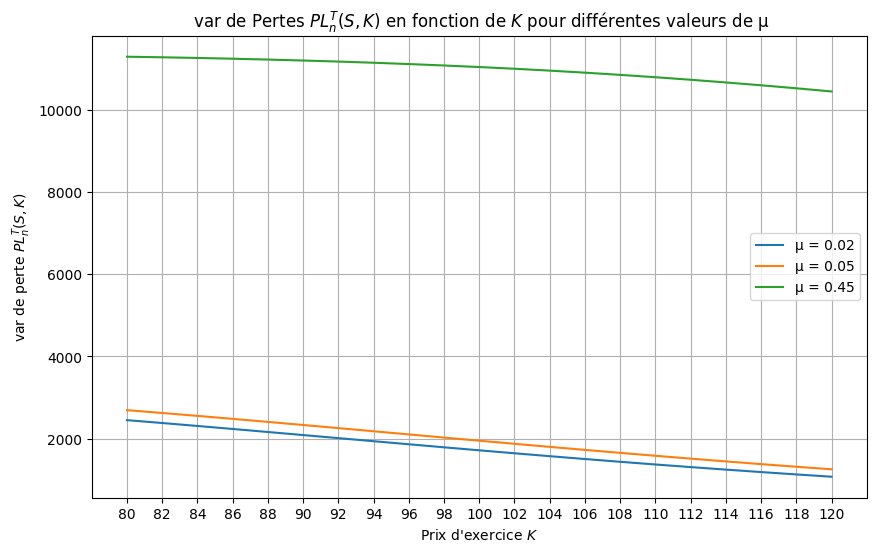

In [9]:
n1 = 100
mean_PLn_T_resultats = {}
var_PLn_T_resultats = {}
for mu in valeur_mu:
    PLn_T = calculer_PLn_T(S0, mu, sigma, T, n1, m, r, valeur_K)
    mean_PLn_T_resultats[mu] = np.mean(PLn_T, axis=1)  # Moyenne des pertes pour chaque K
    var_PLn_T_resultats[mu]= np.var(PLn_T, axis=1)

# Tracer les pertes en fonction de K pour chaque mu
plt.figure(figsize=(10, 6))

for mu in valeur_mu:
    plt.plot(valeur_K, mean_PLn_T_resultats[mu], label=f'μ = {mu}')

plt.title('Pertes moyenne $PL_n^T(S, K)$ en fonction de $K$ pour différentes valeurs de μ')
plt.xlabel('Prix d\'exercice $K$')
plt.ylabel('Pertes moyennes $PL_n^T(S, K)$')
plt.xticks(valeur_K)  # Afficher les valeurs de K sur l'axe des x
plt.legend()
plt.grid(True)
plt.show()


# Tracer les variances des pertes en fonction de K pour chaque mu
plt.figure(figsize=(10, 6))

for mu in valeur_mu:
    plt.plot(valeur_K, var_PLn_T_resultats[mu], label=f'μ = {mu}')

plt.title(' var de Pertes $PL_n^T(S, K)$ en fonction de $K$ pour différentes valeurs de μ')
plt.xlabel('Prix d\'exercice $K$')
plt.ylabel('var de perte $PL_n^T(S, K)$')
plt.xticks(valeur_K)  # Afficher les valeurs de K sur l'axe des x
plt.legend()
plt.grid(True)
plt.show()

On remarque l'effet de $\mu$ toutefois changer $n$ n'a pas trop de difference sur la perte et dans les deux car la variance de la perte est pareil